<h2>What is a Kalman Filter?</h2>

The Kalman filter is an algorithm that uses noisy observations of a system over time to estimate the parameters of the system (some of which are unobservable) and predict future observations. At each time step, it makes a prediction, takes in a measurement, and updates itself based on how the prediction and measurement compare.

The algorithm is as follows:
1. Take as input a mathematical model of the system, i.e.
  * the transition matrix, which tells us how the system evolves from one state to another. For instance, if we are modeling the movement of a car, then the next values of position and velocity can be computed from the previous ones using kinematic equations. Alternatively, if we have a system which is fairly stable, we might model its evolution as a random walk. If you want to read up on Kalman filters, note that this matrix is usually called $A$.
  * the observation matrix, which tells us the next measurement we should expect given the predicted next state. If we are measuring the position of the car, we just extract the position values stored in the state. For a more complex example, consider estimating a linear regression model for the data. Then our state is the coefficients of the model, and we can predict the next measurement from the linear equation. This is denoted $H$.
  * any control factors that affect the state transitions but are not part of the measurements. For instance, if our car were falling, gravity would be a control factor. If the noise does not have mean 0, it should be shifted over and the offset put into the control factors. The control factors are summarized in a matrix $B$ with time-varying control vector $u_t$, which give the offset $Bu_t$.
  * covariance matrices of the transition noise (i.e. noise in the evolution of the system) and measurement noise, denoted $Q$ and $R$, respectively.
2. Take as input an initial estimate of the state of the system and the error of the estimate, $\mu_0$ and $\sigma_0$.
3. At each timestep:
  * estimate the current state of the system $x_t$ using the transition matrix
  * take as input new measurements $z_t$
  * use the conditional probability of the measurements given the state, taking into account the uncertainties of the measurement and the state estimate, to update the estimated current state of the system $x_t$ and the covariance matrix of the estimate $P_t$

[This graphic](https://upload.wikimedia.org/wikipedia/commons/a/a5/Basic_concept_of_Kalman_filtering.svg) illustrates the procedure followed by the algorithm. 

It's very important for the algorithm to keep track of the covariances of its estimates. This way, it can give us a more nuanced result than simply a point value when we ask for it, and it can use its confidence to decide how much to be influenced by new measurements during the update process. The more certain it is of its estimate of the state, the more skeptical it will be of measurements that disagree with the state.

By default, the errors are assumed to be normally distributed, and this assumption allows the algorithm to calculate precise confidence intervals. It can, however, be implemented for non-normal errors.

In [1]:
from pykalman import KalmanFilter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import poly1d

### Moving Average

In [2]:
# retrieve APPLE stock price as example
aapl = pd.read_csv("C:/Users/j291414/Desktop/AAPL.csv")
aapl['Date'] = pd.to_datetime(aapl['Date'], format='%d/%m/%Y')

# construct a Kalman filter
kf = KalmanFilter(transition_matrices = [1],
                 observation_matrices = [1],
                 initial_state_mean = 0,
                 initial_state_covariance = 1,
                 observation_covariance = 1,
                 transition_covariance = 0.01)


In [3]:
state_means, _ = kf.filter(aapl['Adj Close'])
state_means = pd.Series(state_means.flatten(), index=aapl['Date'])

In [4]:
mean30 = aapl['Adj Close'].rolling(window=30).mean()
mean60 = aapl['Adj Close'].rolling(window=60).mean()
mean90 = aapl['Adj Close'].rolling(window=90).mean()

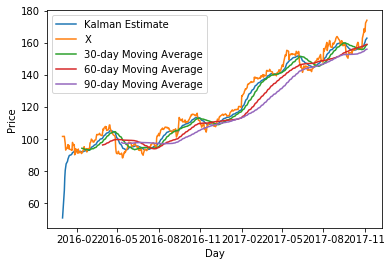

In [5]:
plt.plot(state_means)
plt.plot(aapl['Date'], aapl['Adj Close'])
plt.plot(aapl['Date'],mean30)
plt.plot(aapl['Date'],mean60)
plt.plot(aapl['Date'],mean90)
plt.legend(['Kalman Estimate', 'X', '30-day Moving Average', '60-day Moving Average','90-day Moving Average'])
plt.xlabel('Day')
plt.ylabel('Price')
plt.show()

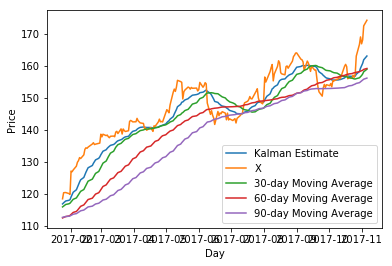

In [6]:
plt.plot(state_means[-200:])
plt.plot(aapl['Date'][-200:], aapl['Adj Close'][-200:])
plt.plot(aapl['Date'][-200:],mean30[-200:])
plt.plot(aapl['Date'][-200:],mean60[-200:])
plt.plot(aapl['Date'][-200:],mean90[-200:])
plt.legend(['Kalman Estimate', 'X', '30-day Moving Average', '60-day Moving Average','90-day Moving Average'])
plt.xlabel('Day')
plt.ylabel('Price')
plt.show()

<h1 style="color:red">Kalman Filter in Linear Regression</h1>

In [7]:
# load data
data = pd.read_csv('C:/Users/j291414/Desktop/data.csv')
data['Date'] = pd.to_datetime(data['Date'], format="%d/%m/%Y")
x = data['CN']
x.index = data['Date']
y = data['EU']
y.index = data['Date']

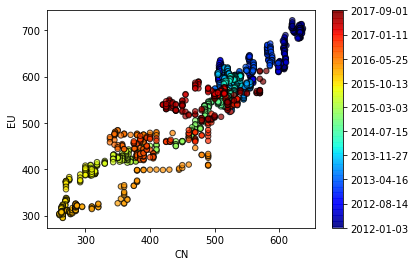

In [8]:
# Plot data and use colormap to indicate the date each point corresponds to
cm = plt.get_cmap('jet')
colors = np.linspace(0.1, 1, len(x))
sc = plt.scatter(x, y, s=30, c=colors, cmap=cm, edgecolor='k', alpha=0.7)
cb = plt.colorbar(sc)
cb.ax.set_yticklabels([str(p.date()) for p in x[::len(x)//9].index])
plt.xlabel('CN')
plt.ylabel('EU')
plt.show()

In [44]:
delta = 1e-3
trans_cov = delta / (1-delta) * np.eye(2)
obs_mat = np.expand_dims(np.vstack([[x], [np.ones(len(x))]]).T, axis=1)

kf = KalmanFilter(n_dim_obs=1, n_dim_state=2,
                  initial_state_mean=[0,0],
                  initial_state_covariance=np.ones((2,2)),
                  transition_matrices=np.eye(2),
                  observation_matrices=obs_mat,
                  observation_covariance=2,
                  transition_covariance=trans_cov
                 )

In [24]:
state_means, state_covs = kf.filter(y.values)

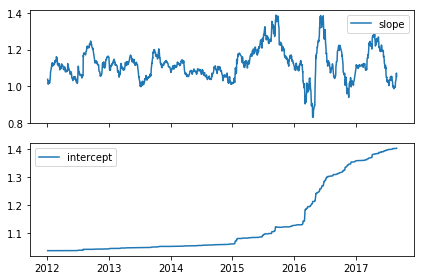

In [29]:
_, axarr = plt.subplots(2, sharex=True)
axarr[0].plot(x.index, state_means[:,0], label='slope')
axarr[0].legend()
axarr[1].plot(x.index, state_means[:,1], label='intercept')
axarr[1].legend()
plt.tight_layout()
plt.show()

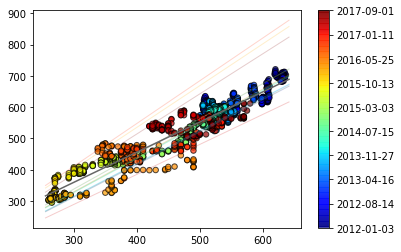

In [39]:
# Plot data points using colormap
sc = plt.scatter(x, y, s=30, c=colors, cmap=cm, edgecolor='k', alpha=0.7)
cb = plt.colorbar(sc)
cb.ax.set_yticklabels([str(p.date()) for p in x[::len(x)//9].index])

# Plot every fifth line
step = 100
xi = np.linspace(x.min()-5, x.max()+5, 2)
colors_l = np.linspace(0.1, 1, len(state_means[::step]))
for i, beta in enumerate(state_means[::step]):
    plt.plot(xi, beta[0] * xi + beta[1], alpha=.2, lw=1, c=cm(colors_l[i]))
    
# Plot the OLS regression line
plt.plot(xi, poly1d(np.polyfit(x, y, 1))(xi), '0.4')

plt.show()


In [38]:
np.linspace(x.min()-5, x.max()+5, 2)

array([ 255.    ,  641.7341])

In [41]:
np.array([1,2]).shape

(2L,)

In [42]:
obs_mat.shape

(1396L, 1L, 2L)